In [1]:
#APERTURA FILE, IMPORTS, LETTURA COLONNE, CREAZIONE COSTANTI

import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle
df = pd.read_excel('data/Informatica.xlsx')
#df.sort_values(by=['STU_ID'])


#colonna di data superamento, freq., anno esame, avvio carriera
passed_date_column = df.DATA_SUP
freq_date_column = df.DATA_FREQ
anno_exam = df.AA_OFF_ID
anno_carriera = df.ANNO_AVVIO_CARRIERA
#colonna studenti, codice esame, stato esame, voto, CFU
student_column = df.STU_ID 
cod_column = df.COD
state_column = df.STA_SCE_COD
mark_column = df.VOTO
#cfu_column = df.PESO
#colonna studenti, codice esame singoli, non ripetuti
single_student = df.STU_ID.unique()
single_cod = df.COD.unique()
#conteggio di quante volte compare un esame
cod_count = df.pivot_table(index=['COD'], aggfunc='size')
#numero di righe
rows = len(student_column)
#numero mesi /3 di analisi dall'inizio carriera
n_month = 18          #54 mesi

In [2]:
print(len(passed_date_column))
print(len(freq_date_column))
print(len(anno_exam))
print(len(anno_carriera))
print(len(student_column))
print(len(cod_column))
print(len(state_column))
print(len(mark_column))


passed_date_column = np.array(passed_date_column)
freq_date_column = np.array(freq_date_column)
anno_exam = np.array(anno_exam)
anno_carriera = np.array(anno_carriera)
student_column = np.array(student_column)
cod_column = np.array(cod_column)
state_column = np.array(state_column)
mark_column = np.array(mark_column)

i = 0
c_list = []
for stu in student_column:
  if anno_carriera[i] >= 2018:
    c_list.append(i)
    print("inserito")
  i += 1

print(c_list)

passed_date_column = np.delete(passed_date_column, c_list)
freq_date_column = np.delete(freq_date_column, c_list)
anno_exam = np.delete(anno_exam, c_list)
anno_carriera = np.delete(anno_carriera, c_list)
student_column = np.delete(student_column, c_list)
cod_column = np.delete(cod_column, c_list)
state_column = np.delete(state_column, c_list)
mark_column = np.delete(mark_column, c_list)

print(len(passed_date_column))
print(len(freq_date_column))
print(len(anno_exam))
print(len(anno_carriera))
print(len(student_column))
print(len(cod_column))
print(len(state_column))
print(len(mark_column))

rows = len(student_column)

7025
7025
7025
7025
7025
7025
7025
7025
inserito
inserito
inserito
inserito
inserito
[7020, 7021, 7022, 7023, 7024]
7020
7020
7020
7020
7020
7020
7020
7020


In [ ]:
#CREAZIONE DIZIONARIO ESAMI DEGLI STUDENTI

#creazione array esami da scartare
i = 0
excluded_exam = []
for exam in cod_column:
  if (state_column[i]=='S' and not mark_column[i]==mark_column[i]  and not (cod_column[i] in excluded_exam) ):
    excluded_exam.append(cod_column[i])
  i+= 1

#dizionario esami, inizializzato a 0 per gli esami che non sono tirocini, tesi e sono stati svolti da almeno 20 studenti
exam_dict = dict()
for cod in single_cod :
  if ( cod_count[cod] > 3 and not cod in excluded_exam):
    exam_dict[cod] = [0]
    k = 0 
    while k < (n_month-1):
      exam_dict[cod].append(0)
      k += 1



In [ ]:
#ANALISI DEI DATI

i = 0 #indice di riga
student_list = []
finalexam_list = []
time_list = []
quit_list = []
#per ogni studente, si crea una sua lista di esami, copiando il dizionario

for student in single_student:

  start_year = anno_carriera[i]+1                                           #ottengo il suo anno di immatricolazione
  exam_list = exam_dict.copy()                                            #creo la lista dei suoi esami
  graduated = False                                                       #inizializzo la laurea a false
  quit = False                                                            #inizializzo il quit a false
  sus_quit_array = [0] * n_month                                          #array di sospetto abbandono
  grad_block = 19                                                          #inizializzo a 0 per chi non si laurea/non si laurea in tempo nell'analisi
  
  while (student == student_column[i]):                                   #iterazione degli esami basata sull'id dello studente
    
    if (cod_column[i] in exam_list):                                      #si verificano tutti i suoi esami, se compresi nel dizionario
      
      passed_block = n_month                                              #inizializzo nel caso non abbia passato l'esame
      
      if state_column[i]=='S':                                            #controlla se ha superato l'esame
        month = passed_date_column[i][5:7]                                 #mese di superamento
        month = int(month)
        year = passed_date_column[i][:4]                                #anno superamento 
        year = int(year)
        
        diff = ((year-start_year)*12+(month-1))                           #calcolo data di superamento e blocco di campionamento (uso il 1° gennaio)
        passed_block = int(diff/3)-1                                      #campionamento del tempo nella suddivisione ogni 3 mesi
        resto = diff%3                                                    
        if (resto != 0):                                                  #se c'è un resto passa al blocco successivo
          passed_block+= 1
        if passed_block > (n_month-1):
          passed_block = n_month
      
      if freq_date_column[i]==freq_date_column[i]:                        #se frequentato NON è vuoto calcola nuove date per la freq, altrimenti usa quelle di superamento (esame importato)
        month = freq_date_column[i][5:7]
        month = int(month)
        year = freq_date_column[i][:4]
        year = int(year)        

      diff = ((year-start_year)*12+(month-1))                             #calcolo data di frequenza e blocco di campionamento
      freq_block = int(diff/3)-1
      resto = diff%3             
      if (resto != 0):
        freq_block+= 1

      k = 0
      exam_list[cod_column[i]] = []
      while k<n_month:                                                    #per ogni esame creo un array di tempo con valori 0,1,2 in base a quando ha non frequentato, frequentato e passato l'esame
        if k < freq_block:
          exam_list[cod_column[i]].append(0)
        elif k < passed_block:
          exam_list[cod_column[i]].append(1)
        else:
          exam_list[cod_column[i]].append(2)
          sus_quit_array[k]+=1
        k +=1

    elif cod_column[i] == 14250 and state_column[i]=='S':                 #si verifica se è laureato, L'UNICA SPECIFICA PIù GENERALE SAREBBE CHECKARE IL CAMPO NOME == 'PROVA FINALE'
      graduated = True
      month = passed_date_column[i][5:7]
      month = int(month)
      year = passed_date_column[i][:4]                                
      year = int(year)
      grad_diff = ((year-start_year)*12+(month-1))                             #n° mesi per laurearsi
      """
      if grad_diff > n_month*3:
        graduated = False
        grad_diff = 0
      """
      grad_block = int(grad_diff/3)-1
      resto = grad_diff%3             
      if (resto != 0):
        grad_block+= 1
      if grad_block > (n_month):
        grad_block = 19                                   #imposto un tetto generale nel caso qualcuno si laurei oltre la soglia
        graduated = False
      
    
    i+= 1                                                                 #incremento contatore di linea degli esami
    if (i==rows-1):                                                         #check fine del file per evitare errori
      break
  
  index_array = []                                                        #creo l'array in cui inserisco l'indice dei blocchi con sospetto abbandono
  temp_matrix = np.transpose(list(exam_list.values()))                    #creo la matrice trasposta, in modo da avere un array di tempi con gli status dei vari esami
  for counter in range(0,len(sus_quit_array)-2,3):

#    CHECK ABBANDONO
    if (sus_quit_array[counter] == sus_quit_array[counter+1] and sus_quit_array[counter+1] == sus_quit_array[counter+2]):
      quit = True                            
    
    array_to_append = temp_matrix[counter].tolist()                                #creo gli array con il tempo come ultimo numero
    array_to_append.append(counter*3)
    student_list.append(array_to_append)                                  #insert nella lista della matrice trasposta
    
    array_to_append = temp_matrix[counter+1].tolist() 
    array_to_append.append((counter+1)*3)   
    student_list.append(array_to_append)
    
    array_to_append = temp_matrix[counter+2].tolist()    
    array_to_append.append((counter+2)*3)
    student_list.append(array_to_append)

  if (graduated):                                                         #check se è laureato, 0=non laureato, 1=laureato, 2=non laureato sospetto abbandono, 3=laureato sospetto abbandono
    for counter in range(0,int(n_month)):
      finalexam_list.append(1)
  else:
    for counter in range(0,int(n_month)):
      finalexam_list.append(0)

  for counter in range(0,int(n_month)):
        time_list.append(grad_block)

  if (quit):                                                         #check se è laureato, 0=non laureato, 1=laureato, 2=non laureato sospetto abbandono, 3=laureato sospetto abbandono
    for counter in range(0,int(n_month)):
      quit_list.append(1)
  else:
    for counter in range(0,int(n_month)):
      quit_list.append(0)



In [ ]:
#CREAZIONE ARRAY FINALI, SHUFFLE E PRINT DATI

student_list = np.array (student_list)
finalexam_list = np.array (finalexam_list)
time_list = np.array(time_list)
quit_list = np.array(quit_list)
student_list, finalexam_list, time_list, quit_list = shuffle (student_list, finalexam_list, time_list, quit_list)


import sys                                                               #print options
np.set_printoptions(threshold=sys.maxsize)



print(student_list)
print(finalexam_list)
print(time_list)
print(quit_list)
print("Lunghezza array studenti: ", len(student_list))
print("Lunghezza array laurea: ", len(finalexam_list))
print("Lunghezza array tempi: ", len(time_list))
print("Lunghezza array abbandoni: ", len(quit_list))


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 12]
 [ 2  2  2  2  2  2  0  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 42]
 [ 1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 33]
 [ 2  2  2  2  2  2  0  2  2  2  2  0  2  2  2  2  2  0  2  2  0  0  0  0
   0  0  0  0  0  0  0  0  0 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 33]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 24]
 [ 1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 48]
 [ 2  2  2  2  2  2  2  2  1  2  1  2

In [ ]:
#CUT e RESCALING calcolo tempi

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

student_list_time = student_list


cancel_list = []
i = 0
while i < len(student_list_time):
  if time_list[i] < 10:
    cancel_list.append(i)
  i+= 1

student_list_time = np.delete(student_list_time, cancel_list, axis=0)
time_list = np.delete(time_list, cancel_list)


time_list = scaler.fit_transform(time_list.reshape(-1,1))
print(time_list)
print(len(time_list))
print(len(student_list_time))

[[1.        ]
 [0.11111111]
 [1.        ]
 [0.44444444]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.44444444]
 [0.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.44444444]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.22222222]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.44444444]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.55555556]
 [0.11111111]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [0.55555556]
 [1.        ]
 [1.  

In [ ]:
#INVERSO RESCALING
time_list = scaler.inverse_transform(time_list)
print(time_list)

In [ ]:
#IMPORT RETE NEURALE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
#RETE NEURALE CALCOLO LAUREA

n_exam= len(exam_dict)
graduation_model = Sequential ([
                     Dense(units = 26, input_shape=(n_exam+1, ), activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     #Flatten(),
                     Dense(units=2, activation='softmax')
])

graduation_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 26)                910       
_________________________________________________________________
dense_41 (Dense)             (None, 50)                1350      
_________________________________________________________________
dense_42 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_43 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_44 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_45 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_46 (Dense)             (None, 2)                

In [ ]:
#RETE NEURALE CALCOLO TEMPI

n_exam= len(exam_dict)
time_model = Sequential ([
                     Dense(units = 64, input_shape=(n_exam+1, ), activation='relu'),
                     Dense(units= 128, activation='relu'),
                     Dense(units= 128, activation='relu'),
                     Dense(units= 128, activation='relu'),
                     Dense(units= 128, activation='relu'),
                     Dense(units=1)
])

time_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                2240      
_________________________________________________________________
dense_48 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 129       
Total params: 60,225
Trainable params: 60,225
Non-trainable params: 0
__________________________________________________

In [ ]:
#RETE NEURALE CALCOLO ABBANDONI

n_exam= len(exam_dict)
quit_model = Sequential ([
                     Dense(units = 26, input_shape=(n_exam+1, ), activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     Dense(units= 50, activation='relu'),
                     #Flatten(),
                     Dense(units=2, activation='softmax')
])

quit_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 26)                910       
_________________________________________________________________
dense_54 (Dense)             (None, 50)                1350      
_________________________________________________________________
dense_55 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_56 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_57 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_58 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_59 (Dense)             (None, 2)                

In [ ]:
#LOAD MODEL
from tensorflow.keras.models import load_model

graduation_model = load_model('/content/drive/MyDrive/Colab Notebooks/informatica_lauree.h5')
graduation_model.load_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi.h5')
graduation_model.summary()

time_model = load_model('/content/drive/MyDrive/Colab Notebooks/informatica_tempi.h5')
time_model.load_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi.h5')
time_model.summary()

quit_model = load_model('/content/drive/MyDrive/Colab Notebooks/informatica_abbandoni.h5')
quit_model.load_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi.h5')
quit_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 26)                728       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1350      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 2)                

In [ ]:
#TRAINING RETE NEURALE CALCOLO LAUREE

#compila il modulo con queste regole
graduation_model.compile (optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train samples, train labels, insieme di validazione (controllo di over fitting) splitta l'ultimo 10%,
#quanti vengono elaborati insieme (10 alla volta), numero di epoche, shuffle (true default) importantissimo per lo splitting, tipo messaggi di output
history = graduation_model.fit(x=student_list, y=finalexam_list, validation_split=0.2, batch_size=32, epochs=30, shuffle=True, verbose=2)

Epoch 1/30
127/127 - 1s - loss: 0.4199 - accuracy: 0.8293 - val_loss: 0.3318 - val_accuracy: 0.8829
Epoch 2/30
127/127 - 0s - loss: 0.2721 - accuracy: 0.9017 - val_loss: 0.2334 - val_accuracy: 0.9183
Epoch 3/30
127/127 - 0s - loss: 0.2136 - accuracy: 0.9200 - val_loss: 0.2072 - val_accuracy: 0.9173
Epoch 4/30
127/127 - 0s - loss: 0.1852 - accuracy: 0.9251 - val_loss: 0.1803 - val_accuracy: 0.9193
Epoch 5/30
127/127 - 0s - loss: 0.1668 - accuracy: 0.9325 - val_loss: 0.1551 - val_accuracy: 0.9380
Epoch 6/30
127/127 - 0s - loss: 0.1533 - accuracy: 0.9355 - val_loss: 0.1436 - val_accuracy: 0.9380
Epoch 7/30
127/127 - 0s - loss: 0.1434 - accuracy: 0.9392 - val_loss: 0.1366 - val_accuracy: 0.9419
Epoch 8/30
127/127 - 0s - loss: 0.1364 - accuracy: 0.9401 - val_loss: 0.1390 - val_accuracy: 0.9380
Epoch 9/30
127/127 - 0s - loss: 0.1294 - accuracy: 0.9404 - val_loss: 0.1289 - val_accuracy: 0.9409
Epoch 10/30
127/127 - 0s - loss: 0.1214 - accuracy: 0.9498 - val_loss: 0.1353 - val_accuracy: 0.9350

In [ ]:
#TRAINING RETE NEURALE CALCOLO TEMPO

#optimizer=tf.keras.optimizers.RMSprop(0.001)
#optimizer=Adam(learning_rate=0.0001)
#loss='mse', metrics=['mae', 'mse']

time_model.compile (optimizer='adam', loss='mse')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = time_model.fit(x=student_list_time, y=time_list, validation_split=0.3, batch_size=18, epochs=100, shuffle=True, verbose=2, callbacks=[early_stop])

Epoch 1/100
191/191 - 1s - loss: 0.1677 - val_loss: 0.0421
Epoch 2/100
191/191 - 0s - loss: 0.0438 - val_loss: 0.0449
Epoch 3/100
191/191 - 0s - loss: 0.0313 - val_loss: 0.0268
Epoch 4/100
191/191 - 0s - loss: 0.0253 - val_loss: 0.0411
Epoch 5/100
191/191 - 0s - loss: 0.0238 - val_loss: 0.0322
Epoch 6/100
191/191 - 0s - loss: 0.0221 - val_loss: 0.0234
Epoch 7/100
191/191 - 0s - loss: 0.0209 - val_loss: 0.0211
Epoch 8/100
191/191 - 0s - loss: 0.0195 - val_loss: 0.0224
Epoch 9/100
191/191 - 0s - loss: 0.0204 - val_loss: 0.0233
Epoch 10/100
191/191 - 0s - loss: 0.0186 - val_loss: 0.0234
Epoch 11/100
191/191 - 0s - loss: 0.0175 - val_loss: 0.0192
Epoch 12/100
191/191 - 0s - loss: 0.0176 - val_loss: 0.0199
Epoch 13/100
191/191 - 0s - loss: 0.0176 - val_loss: 0.0190
Epoch 14/100
191/191 - 0s - loss: 0.0159 - val_loss: 0.0232
Epoch 15/100
191/191 - 0s - loss: 0.0191 - val_loss: 0.0284
Epoch 16/100
191/191 - 0s - loss: 0.0168 - val_loss: 0.0251
Epoch 17/100
191/191 - 0s - loss: 0.0162 - val_lo

In [ ]:
#TRAINING RETE NEURALE CALCOLO ABBANDONI

#compila il modulo con queste regole
graduation_model.compile (optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train samples, train labels, insieme di validazione (controllo di over fitting) splitta l'ultimo 10%,
#quanti vengono elaborati insieme (10 alla volta), numero di epoche, shuffle (true default) importantissimo per lo splitting, tipo messaggi di output
history = graduation_model.fit(x=student_list, y=quit_list, validation_split=0.2, batch_size=32, epochs=30, shuffle=True, verbose=2)

Epoch 1/30
127/127 - 1s - loss: 3.6062 - accuracy: 0.7234 - val_loss: 0.4549 - val_accuracy: 0.8858
Epoch 2/30
127/127 - 0s - loss: 0.2782 - accuracy: 0.9241 - val_loss: 0.2243 - val_accuracy: 0.9183
Epoch 3/30
127/127 - 0s - loss: 0.1304 - accuracy: 0.9522 - val_loss: 0.0826 - val_accuracy: 0.9970
Epoch 4/30
127/127 - 0s - loss: 0.0732 - accuracy: 0.9963 - val_loss: 0.0551 - val_accuracy: 0.9970
Epoch 5/30
127/127 - 0s - loss: 0.0605 - accuracy: 0.9963 - val_loss: 0.0468 - val_accuracy: 0.9970
Epoch 6/30
127/127 - 0s - loss: 0.0537 - accuracy: 0.9963 - val_loss: 0.0412 - val_accuracy: 0.9970
Epoch 7/30
127/127 - 0s - loss: 0.0479 - accuracy: 0.9963 - val_loss: 0.0368 - val_accuracy: 0.9970
Epoch 8/30
127/127 - 0s - loss: 0.0426 - accuracy: 0.9963 - val_loss: 0.0324 - val_accuracy: 0.9970
Epoch 9/30
127/127 - 0s - loss: 0.0375 - accuracy: 0.9963 - val_loss: 0.0284 - val_accuracy: 0.9970
Epoch 10/30
127/127 - 0s - loss: 0.0328 - accuracy: 0.9963 - val_loss: 0.0249 - val_accuracy: 0.9970

In [ ]:
import matplotlib.pyplot as plt
from random import randint

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


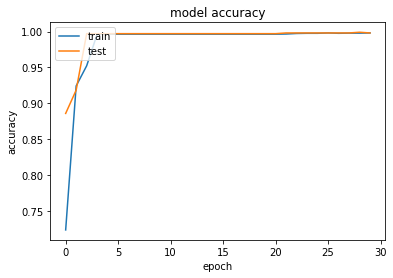

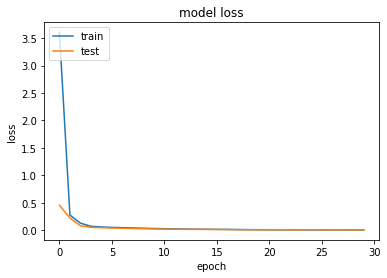

In [ ]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
n_exam= len(exam_dict)

#SUDDIVISIONE ARRAY TEMPI PER CALCOLO ERRORE
print(student_list_time[1240].tolist())
print(student_list_time[1240][n_exam])

i = 0
first_list = []
second_list = []
third_list = []
first_time_list = []
second_time_list = []
third_time_list = []
while i < len(student_list_time):
  if student_list_time[i][n_exam] < 18:
    first_list.append(student_list_time[i].tolist())
    first_time_list.append(time_list[i])
  elif student_list_time[i][n_exam] < 36:
    second_list.append(student_list_time[i].tolist())
    second_time_list.append(time_list[i])
  else:
    third_list.append(student_list_time[i].tolist())
    third_time_list.append(time_list[i])
  i+=1

print(first_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9]
9
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12], [1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 15], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
total_pred = time_model.predict(student_list_time)
first_pred = time_model.predict(first_list)
second_pred = time_model.predict(second_list)
third_pred = time_model.predict(third_list)

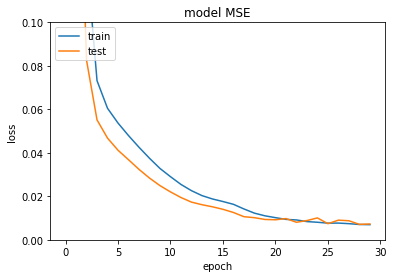

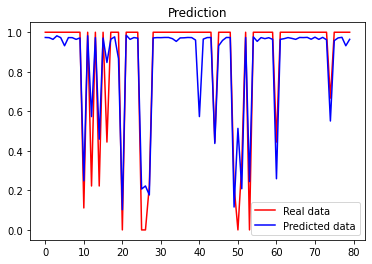

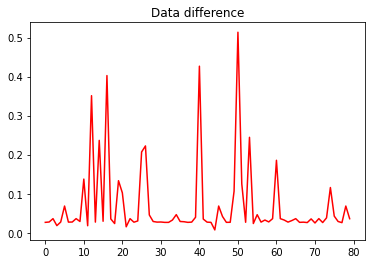

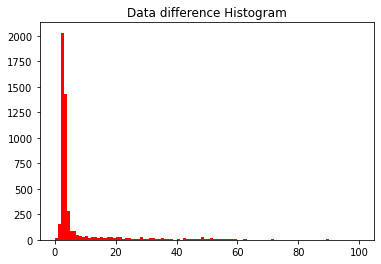

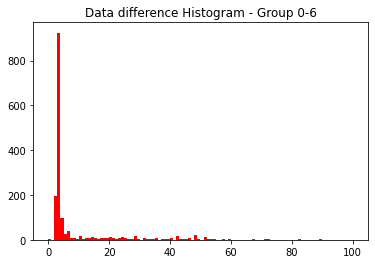

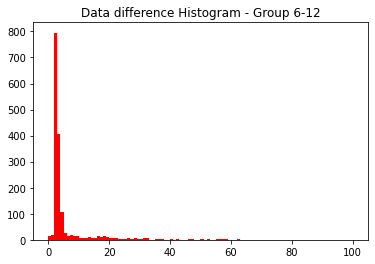

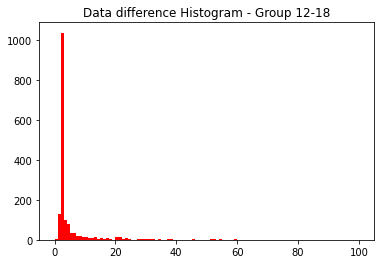

Errore medio sul risultato:  [0.05104034]
Errore medio sul risultato in percentuale:  5.104033747629092 %
Errore medio in mesi:  1.5312101242887275


In [ ]:
#grafico MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim ([0,0.1])
plt.show()

#grafico prediction a confronto
value = randint(0, len(time_list)-80)
plt.plot(time_list[value:value+80], color = 'red', label = 'Real data')
plt.plot(total_pred[value:value+80], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#grafico differenza prediction
diff = time_list - total_pred
plt.plot(np.absolute(diff[value:value+80]), color = 'red')
plt.title('Data difference')
plt.show()

#istogramma TOTALE
diff = time_list - total_pred
abs_diff = np.absolute(diff)
hist_diff = np.multiply(abs_diff, 100)
unique, counts = np.unique(hist_diff.astype(int), return_counts=True)
dict_diff = dict(zip(unique, counts))
plt.hist(hist_diff.astype(int), color = 'red', bins= 100, range = [0,100])
plt.title('Data difference Histogram')
plt.show()

#istogramma primo gruppo
diff = first_time_list - first_pred
abs_diff = np.absolute(diff)
hist_diff = np.multiply(abs_diff, 100)
unique, counts = np.unique(hist_diff.astype(int), return_counts=True)
dict_diff = dict(zip(unique, counts))
plt.hist(hist_diff.astype(int), color = 'red', bins= 100, range = [0,100])
plt.title('Data difference Histogram - Group 0-6')
plt.show()

#istogramma primo gruppo
diff = second_time_list - second_pred
abs_diff = np.absolute(diff)
hist_diff = np.multiply(abs_diff, 100)
unique, counts = np.unique(hist_diff.astype(int), return_counts=True)
dict_diff = dict(zip(unique, counts))
plt.hist(hist_diff.astype(int), color = 'red', bins= 100, range = [0,100])
plt.title('Data difference Histogram - Group 6-12')
plt.show()

#istogramma primo gruppo
diff = third_time_list - third_pred
abs_diff = np.absolute(diff)
hist_diff = np.multiply(abs_diff, 100)
unique, counts = np.unique(hist_diff.astype(int), return_counts=True)
dict_diff = dict(zip(unique, counts))
plt.hist(hist_diff.astype(int), color = 'red', bins= 100, range = [0,100])
plt.title('Data difference Histogram - Group 12-18')
plt.show()

#calcol dell'errore medio
media = sum(np.absolute(diff))/len(diff)
print("Errore medio sul risultato: ", media)
perc = float(media * 100)
print("Errore medio sul risultato in percentuale: ", perc, "%")
month_err = ((perc*(10))/100)*3
print("Errore medio in mesi: ", month_err)


In [ ]:
#SAVE MODEL
import os.path

#SAVE lauree
#graduation_model.save('/content/drive/MyDrive/Colab Notebooks/informatica_lauree.h5')
#model.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_lauree.h5')

#SAVE tempi
time_model.save('/content/drive/MyDrive/Colab Notebooks/informatica_tempi.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_tempi.h5')

#SAVE abbandoni
#quit_model.save('/content/drive/MyDrive/Colab Notebooks/informatica_abbandoni.h5')
#model.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_abbandoni.h5')

"\n#salvare solo i weights\nmodel.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_lauree.h5')\nmodel.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_tempi.h5')\nmodel.save_weights('/content/drive/MyDrive/Colab Notebooks/informatica_pesi_abbandoni.h5')\n"